# MovieLens and Recommender System

### System I: Recommendation Based on Genres

In [3]:
import numpy as np
import pandas as pd
import streamlit as st


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [16]:

from streamlit_jupyter import StreamlitPatcher, tqdm
StreamlitPatcher().jupyter()


#### Load the data

In [5]:
ratings = pd.read_csv('ratings.dat', sep='::', engine = 'python', header=None)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies = pd.read_csv('movies.dat', sep='::', engine = 'python',
                     encoding="ISO-8859-1", header = None)
movies.columns = ['MovieID', 'Title', 'Genres']

In [6]:
rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
#rating_merged


### How recommendations are generated by Genre?

* We are going to recommend movies based on highly-rated by users.

* A scenario to be addressed: how do we come up with a score that has Rating & Number of Ratings embedded inside.

* Our idea is, to keep the Rating schema simple. Add a dimnishing factor. And this can shrink the Movies with less ratings more. And perform less shrinkage on movies with more ratings.

* Here is a scheme, we are coming with: 
    * (avg_rating_of_the_movie * rating_count_of_the_movie + min_rating_of_all_movies * avg_rating_count_of_all_movies) / (rating_count_of_the_movie + avg_rating_count_of_all_movies)


#### Weighted Rating computed for each Movie

In [7]:
movie_rating = rating_merged[['MovieID', 'Rating']].groupby("MovieID").agg(['mean', 'count']).droplevel(0, axis=1).reset_index()

movie_rating.rename(columns={"mean": "Rating", "count": "Rating_count"}, inplace=True)


avg_rating_count = movie_rating['Rating_count'].mean() 
#avg_rating = (movie_rating['Rating'] * movie_rating['Rating_count']).sum() / movie_rating['Rating_count'].sum()
#avg_rating = 2.5
avg_rating = movie_rating['Rating'].min()

movie_rating['Weighted_Rating'] = (movie_rating['Rating'] * movie_rating['Rating_count'] + avg_rating * avg_rating_count)  / (movie_rating['Rating_count'] + avg_rating_count)



#### Data frame is built that has Movies with Genres & Weighted Rating

In [8]:
movie_with_rating = movies.join(movie_rating.set_index('MovieID'), how='left', on="MovieID")

movie_with_rating['Weighted_Rating'].fillna(value=avg_rating, inplace=True)

#movie_with_rating.sort_values(by='Rating_count', ascending=False)[0:30]

In [9]:
genre_movie_ratings = movie_with_rating.copy()
genre_movie_ratings['Genres'] = genre_movie_ratings['Genres'].str.split('|')
genre_movie_ratings = genre_movie_ratings.explode('Genres')
#genre_movie_ratings

### Find movie by genre

In [10]:
def get_all_genre():
    genres = genre_movie_ratings['Genres'].unique()
    
    return genres

In [74]:
def find_top_movies_by_genre(genre, n=10):
    top_movies = genre_movie_ratings[genre_movie_ratings['Genres'] == genre]


    top_movies = top_movies.sort_values(by='Weighted_Rating', ascending=False)
    
    top_movies = top_movies[0:n]
    return top_movies



In [75]:
get_all_genre()

array(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir',
       'Western'], dtype=object)

In [76]:
find_top_movies_by_genre(genre='Drama', n=10)

,MovieID,Title,Genres,Rating,Rating_count,Weighted_Rating
315,318,"Shawshank Redemption, The (1994)",Drama,4.554558,2227.0,4.170345
847,858,"Godfather, The (1972)",Drama,4.524966,2223.0,4.143341
523,527,Schindler's List (1993),Drama,4.510417,2304.0,4.142327
2789,2858,American Beauty (1999),Drama,4.317386,3428.0,4.075268
589,593,"Silence of the Lambs, The (1991)",Drama,4.351823,2578.0,4.034177
1959,2028,Saving Private Ryan (1998),Drama,4.337354,2653.0,4.029195
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Drama,4.292977,2990.0,4.020348
604,608,Fargo (1996),Drama,4.254676,2513.0,3.939032
900,912,Casablanca (1942),Drama,4.412822,1669.0,3.937765
1176,1193,One Flew Over the Cuckoo's Nest (1975),Drama,4.390725,1725.0,3.931993


### System II: Recommendation Based on IBCF

In [294]:
mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()


In [123]:
movies['Genres'] = movies['Genres'].str.split('|')
movies = movies.explode('Genres')


Then merge ratings and movie datasets.

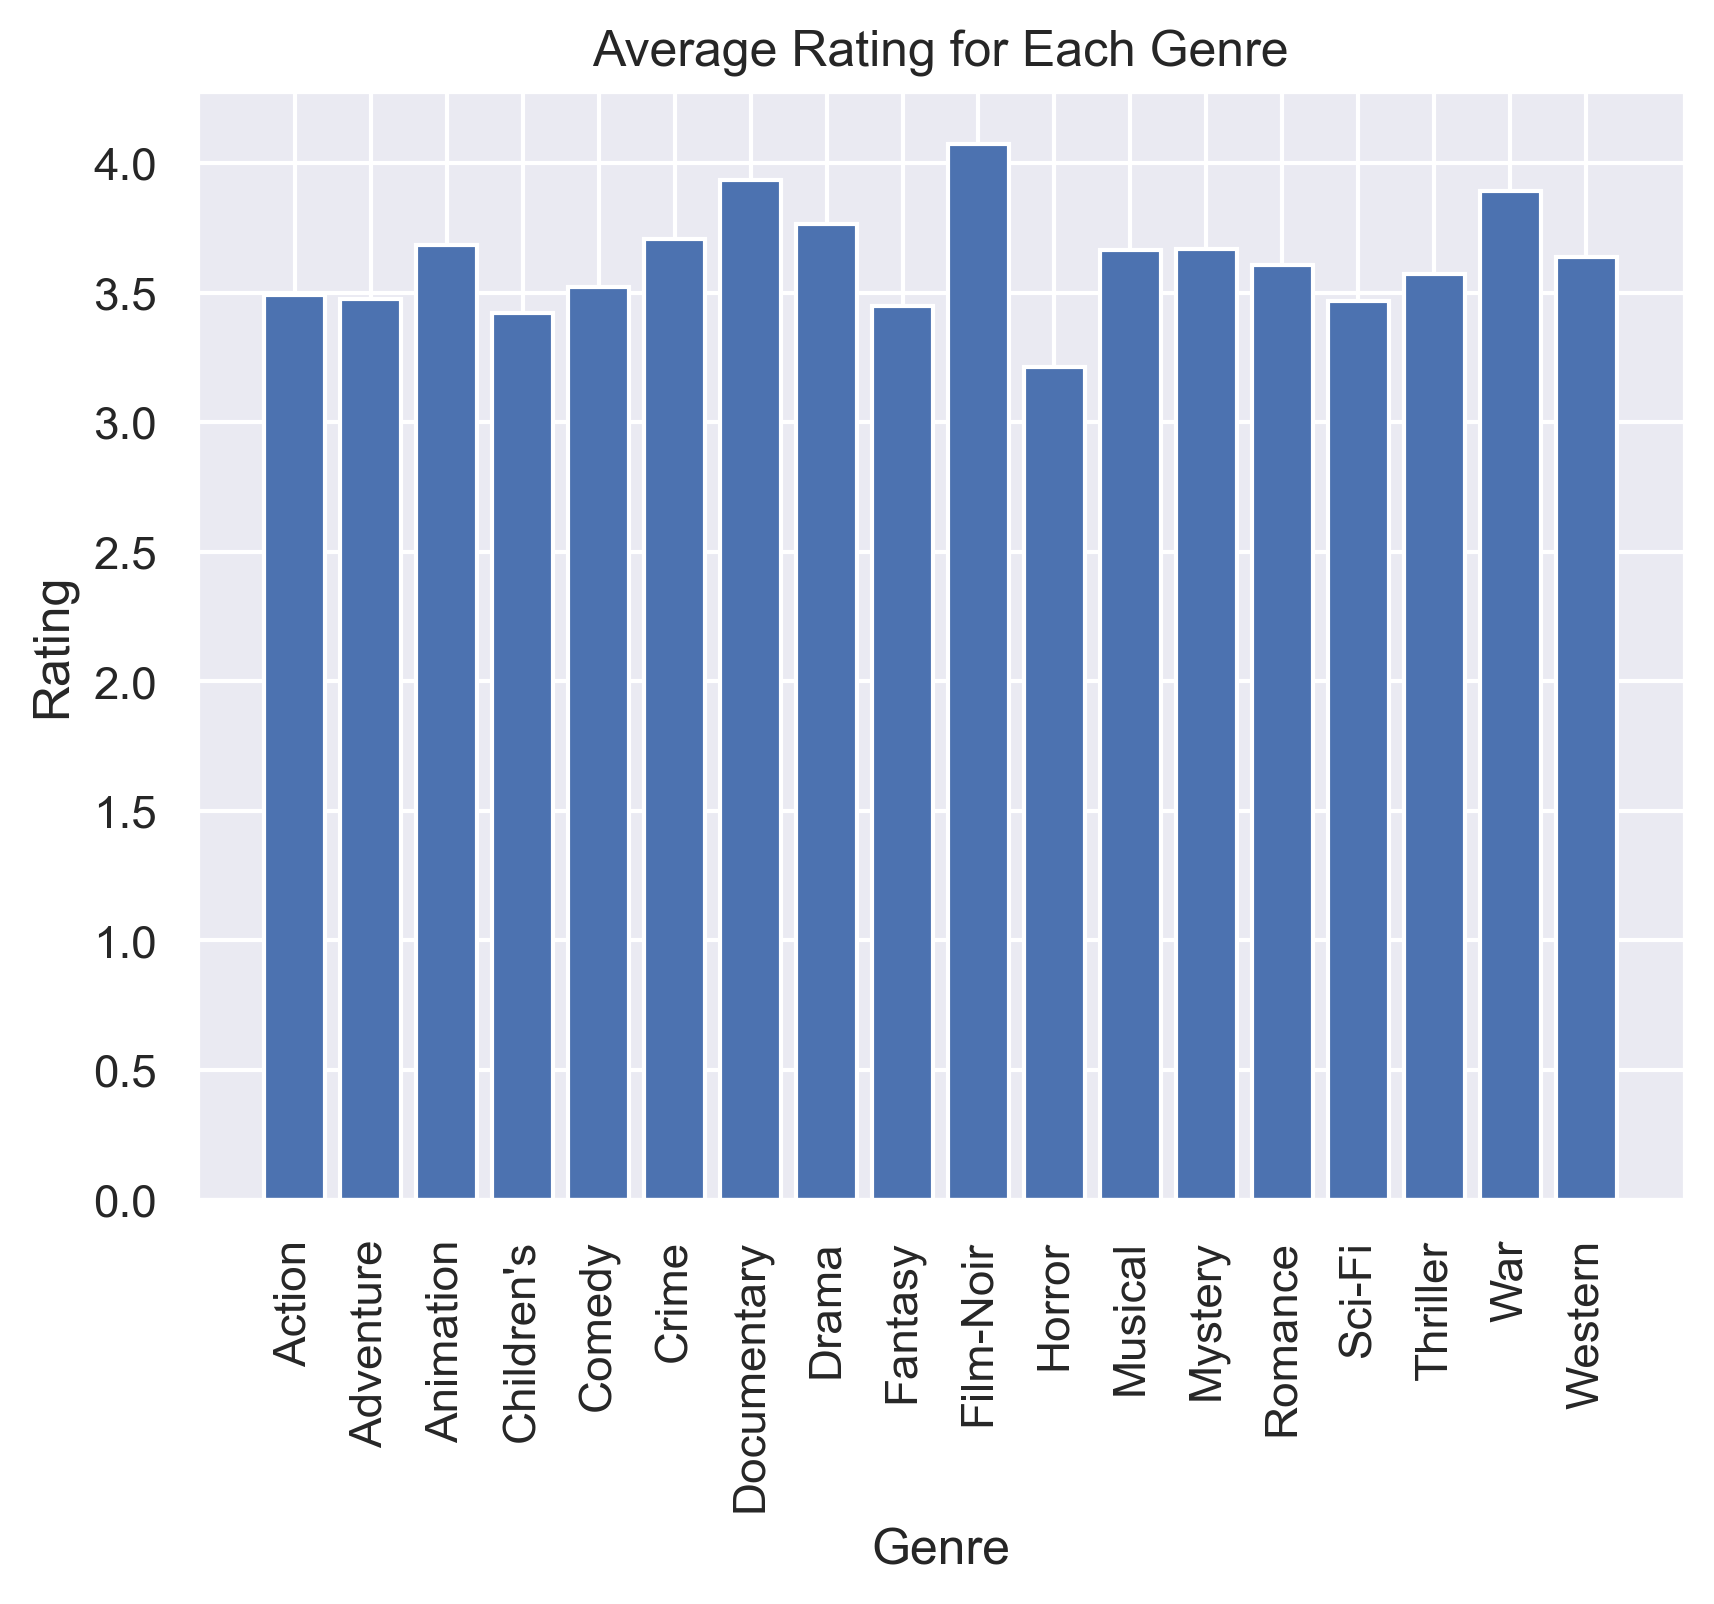

In [67]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 300
sns.set()

plt.bar(mean_ratings.index, mean_ratings['Rating']);
plt.xticks(rotation=90);
plt.title('Average Rating for Each Genre');
plt.xlabel('Genre');
plt.ylabel('Rating');

In [93]:
rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
rating_merged

mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').agg([np.sum, np.mean])
mean_ratings

Rating          
                 sum      mean
Genres                        
Action        898830  3.491185
Adventure     465789  3.477257
Animation     159529  3.684868
Children's    247023  3.422035
Comedy       1255910  3.522099
Crime         294992  3.708679
Documentary    31111  3.933123
Drama        1335274  3.766332
Fantasy       125143  3.447371
Film-Noir      74417  4.075188
Horror        245582  3.215013
Musical       152240  3.665519
Mystery       147377  3.668102
Romance       532184  3.607465
Sci-Fi        545263  3.466521
Thriller      677246  3.570466
War           266798  3.893327
Western        75240  3.637770

In [69]:
df = pd.read_csv('ratings.dat', sep='::', engine = 'python', header=None)
df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [73]:
df = pd.read_csv('movies.dat', sep='::', engine = 'python', encoding="ISO-8859-1", header = None)
df.columns = ['MovieID', 'Title', 'Genres']

print(df.shape)

df['Genres'] = df['Genres'].str.split('|')
df = df.explode('Genres')
print(df.shape)

df

(3883, 3)
(6408, 3)


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children's
0,1,Toy Story (1995),Comedy
1,2,Jumanji (1995),Adventure
1,2,Jumanji (1995),Children's
...,...,...,...
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama


In [74]:
df = pd.read_csv('users.dat', sep='::', engine = 'python', header = None)
df.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zipcode']
df

,UserID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


## Recommender System

Download the MovieLens 1M Dataset. You’ll find four files: README, movies.dat, ratings.dat, and users.dat. Check the readme file to understand the format of the other three files.

In [97]:
import pandas as pd
ratings = pd.read_csv('ratings.dat', sep='::', engine = 'python', header=None)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies = pd.read_csv('movies.dat', sep='::', engine = 'python',
                     encoding="ISO-8859-1", header = None)
movies.columns = ['MovieID', 'Title', 'Genres']

Explore the relationship between movie ratings and movie genres. First, simplify movie genres: multiple genres to ‘Multiple’.

In [98]:
multiple_idx = pd.Series([("|" in movie) for movie in movies['Genres']])
movies.loc[multiple_idx, 'Genres'] = 'Multiple'

In [119]:
rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
rating_merged

mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').agg([np.sum, np.size, np.mean])
#mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()
type(mean_ratings)
mean_ratings.loc[:, :]

Rating                  
                 sum    size      mean
Genres                                
Action         41302   12311  3.354886
Adventure       6339    1711  3.704851
Animation       2017     459  4.394336
Children's       856     290  2.951724
Comedy        404936  116883  3.464456
Crime           6732    1889  3.563790
Documentary    24814    6265  3.960734
Drama         421247  111423  3.780611
Fantasy            4       1  4.000000
Film-Noir       3415     802  4.258105
Horror         69312   22563  3.071932
Multiple     2470049  689510  3.582325
Musical        12193    3211  3.797259
Mystery         4422    1168  3.785959
Romance         7043    2077  3.390948
Sci-Fi         18381    5115  3.593548
Thriller       63476   17851  3.555879
War             3854     991  3.889001
Western        21921    5689  3.853226

In [ ]:
rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
rating_merged

mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').agg([np.sum, np.size, np.mean])
#mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()
type(mean_ratings)
mean_ratings.loc[:, :]

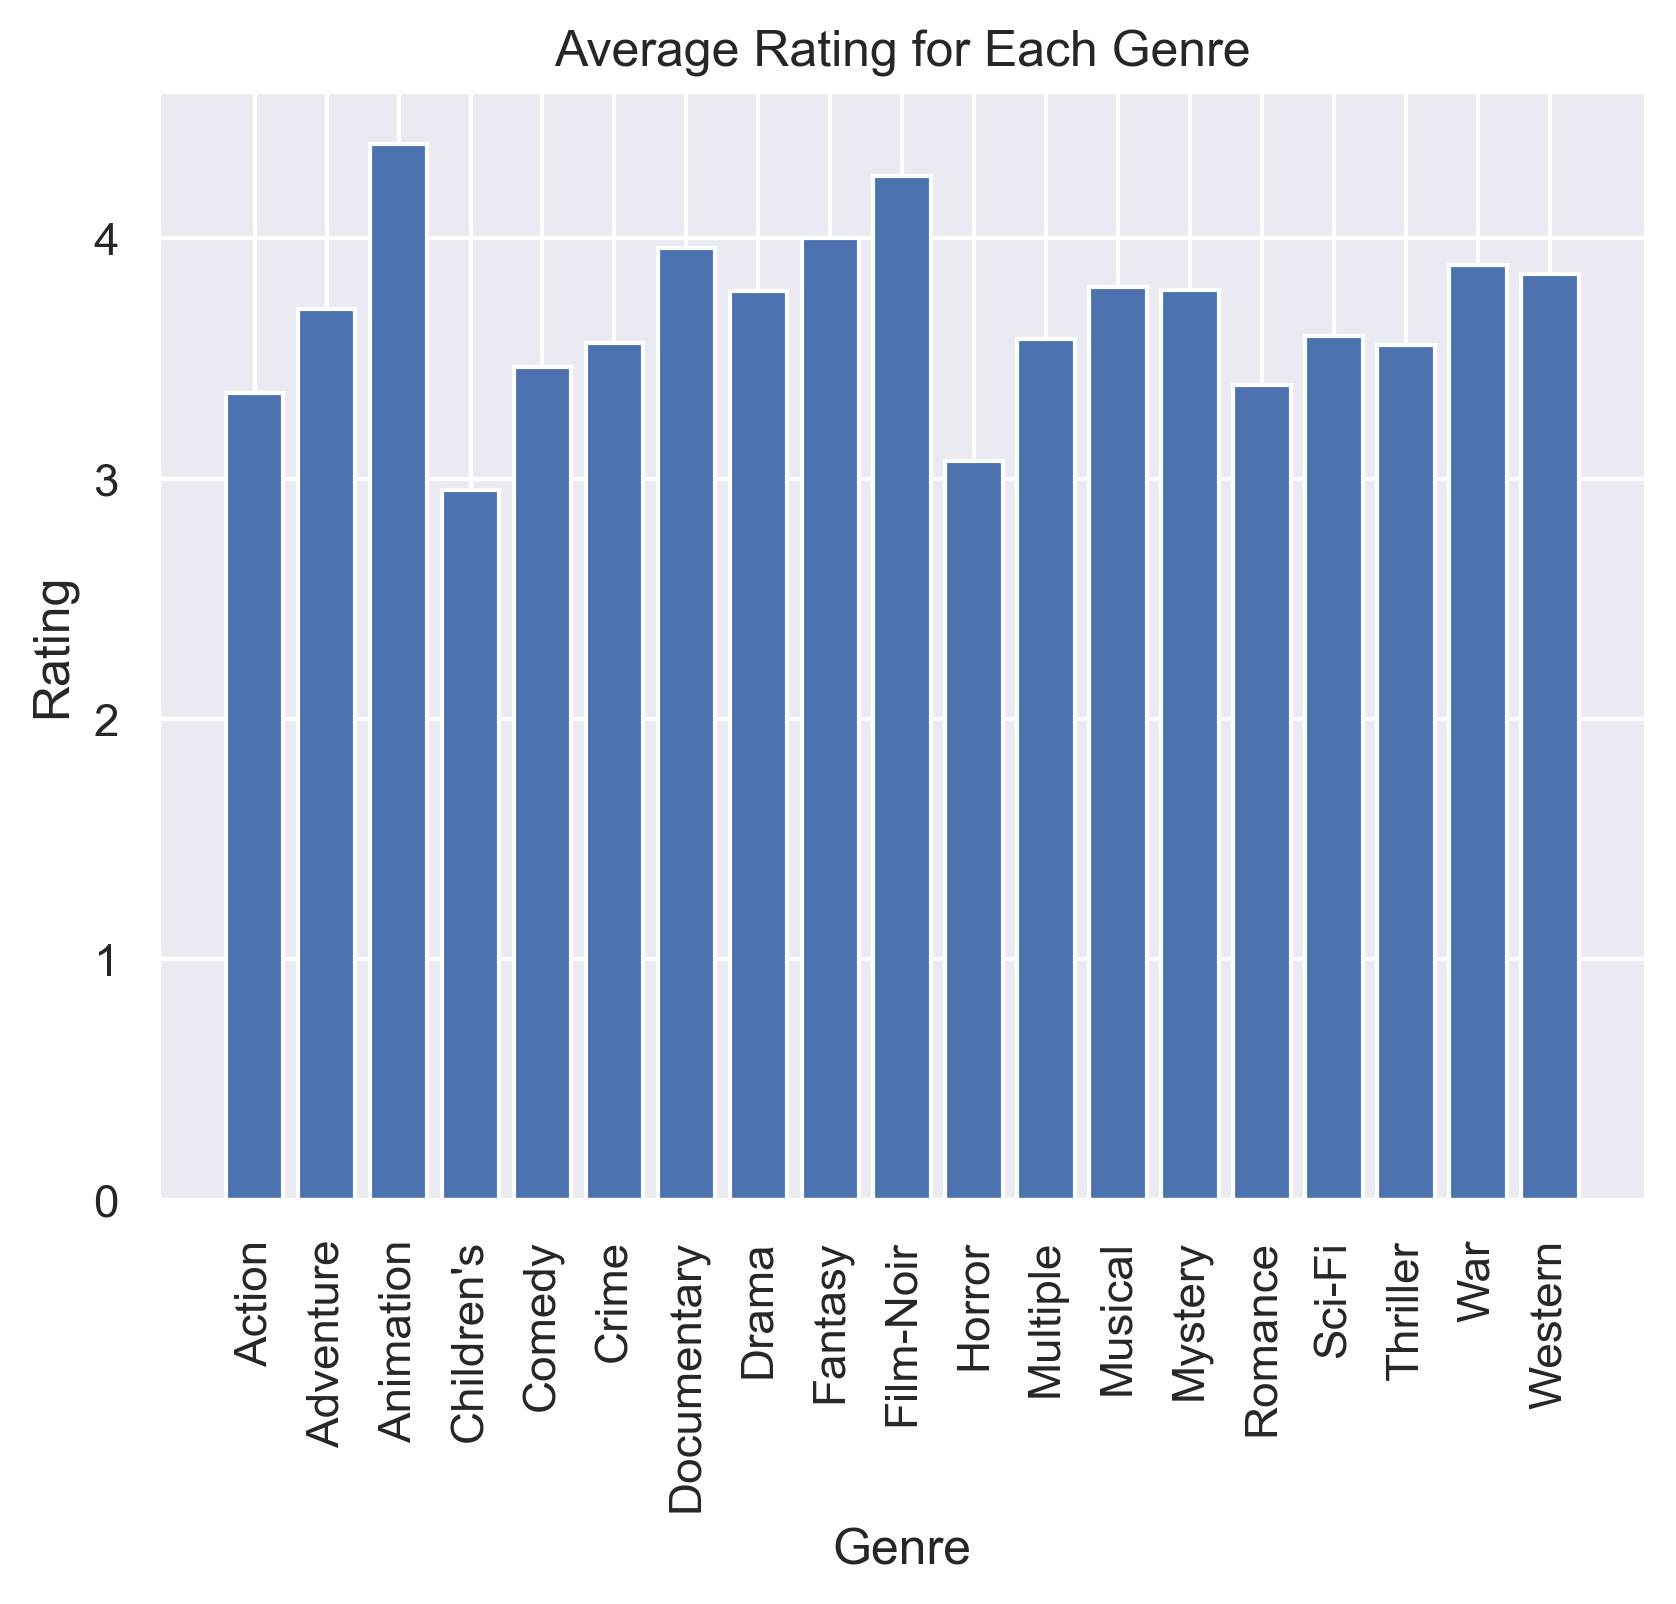

In [105]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 300
sns.set()

rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()
plt.bar(mean_ratings.index, mean_ratings['Rating']);
plt.xticks(rotation=90);
plt.title('Average Rating for Each Genre');
plt.xlabel('Genre');
plt.ylabel('Rating');

## Exploratory Data Analysis

We train a recommender system and make prediction on the test data. We will use the surprise library. First, we must create a dataset object. To do so, we start with a dataframe with columns itemID, userID and rating and use the load_from_df method.

In [78]:
from surprise import Dataset, Reader
ratings = ratings.drop('Timestamp', axis = 1)
ratings.columns = ['userID', 'itemID', 'rating']
ratings = ratings[['itemID', 'userID', 'rating']]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["userID", "itemID", "rating"]], reader)

Next, we will split the data into a train and test.

In [79]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size = 0.25)

We'll use the user-based collaborative filtering method with cosine similarity and normalization.

In [80]:
from surprise.prediction_algorithms.knns import KNNWithZScore
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNWithZScore(sim_options=sim_options).fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Now let’s make prediction on the test data:

In [81]:
import numpy as np
preds = [algo.predict(uid, iid).est for uid, iid, _ in testset]
results_table = pd.DataFrame(np.stack([testset])[0], 
                             columns = ['itemID', 'userID', 'rating'])
results_table['predicted'] = preds
results_merged = results_table.merge(movies, 
                                     left_on = 'itemID', right_on = 'MovieID')
results_merged = results_merged.drop('itemID', axis = 1)
results_merged.sort_values('userID')

,userID,rating,predicted,MovieID,Title,Genres
112685,1.0,5.0,4.213816,301,Picture Bride (1995),Multiple
150685,1.0,4.0,3.993806,1650,Washington Square (1997),Drama
132491,1.0,4.0,3.781002,1484,"Daytrippers, The (1996)",Mystery
3587,1.0,3.0,3.765849,2807,Universal Soldier: The Return (1999),Multiple
131041,1.0,4.0,4.133925,1552,Con Air (1997),Multiple
...,...,...,...,...,...,...
15315,3952.0,4.0,3.709803,524,Rudy (1993),Drama
80113,3952.0,1.0,2.793122,752,Vermont Is For Lovers (1992),Multiple
71718,3952.0,4.0,3.912754,3029,Nighthawks (1981),Multiple
112443,3952.0,3.0,3.539153,1142,Get Over It (1996),Drama
